### Install required dependencies

In [1]:
# !pip install numpy matplotlib

### Load dataset

In [9]:
import numpy as np

# I took this function from tutorials
def prepare_data(filename):
    patterns = []
    with open(filename) as f:
        count, width, height = [int(x) for x in f.readline().split()] # header
        dim = width*height

        for _ in range(count):
            f.readline() # skip empty line
            x = np.empty((height, width))
            for r in range(height):
                x[r,:] = np.array(list(f.readline().strip())) == '#'
            patterns.append(2*x.flatten()-1) # flatten to 1D vector, rescale {0,1} -> {-1,+1}
    
    return patterns, dim

patterns, dim = prepare_data('data.in')
labels = ['X', 'H', 'O', 'Z']

### Corrupt dataset

In [ ]:
def corrupt_patterns(patterns, k):
    corrupted_patterns = []
    for p in patterns:
        cp = np.copy(p)
        indices_to_flip = np.random.choice(len(p), size=k, replace=False)
        cp[indices_to_flip] *= -1
        corrupted_patterns.append(cp)
    return corrupted_patterns

### Train hopfield

In [ ]:
from hopfield import HopfieldNetwork

network = HopfieldNetwork(dim)
network.train(patterns)

### Store results for plotting

In [10]:
results = {}
overlaps = {}
k_noises = [0, 7, 14, 21]
for k in k_noises:
    corrupted_patterns = corrupt_patterns(patterns, k) if k > 0 else list(patterns)
    results[k] = []
    overlaps[k] = [[[] for _ in range (len(patterns))] for _ in range(len(patterns))]
    
    for cpi, cp in enumerate(corrupted_patterns):
        states, energies, _ = network.run_sync(cp)
        for state in states:
            for pi in range(len(patterns)):
                overlaps[k][cpi][pi].append(np.sum(state == patterns[pi]) / len(state))
        results[k].append((states, energies))

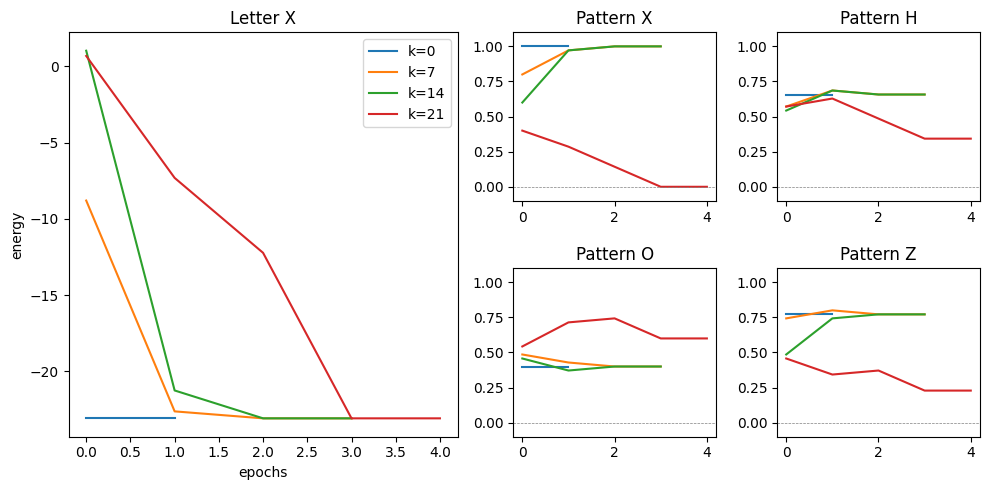

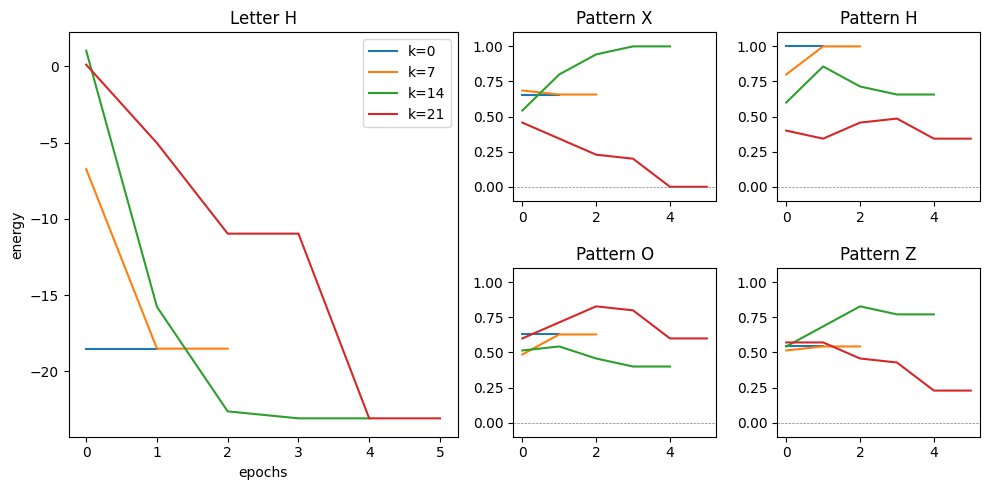

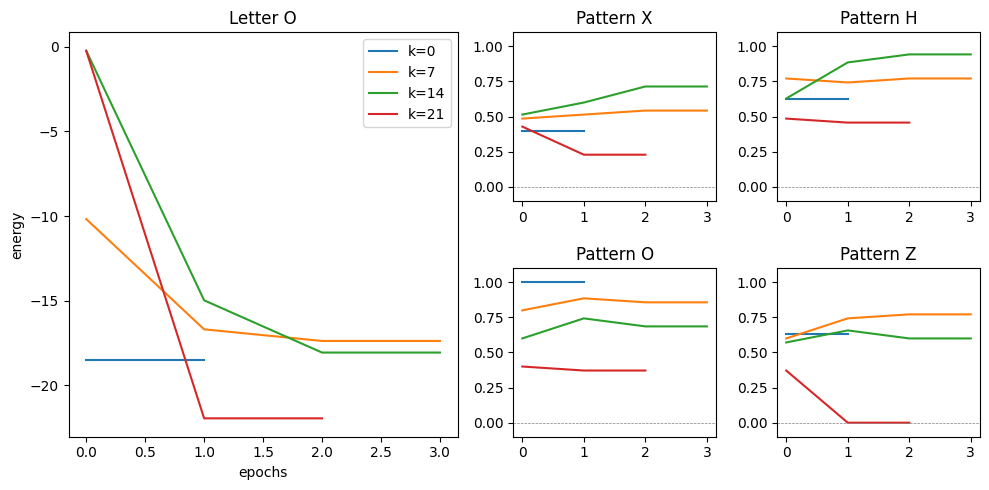

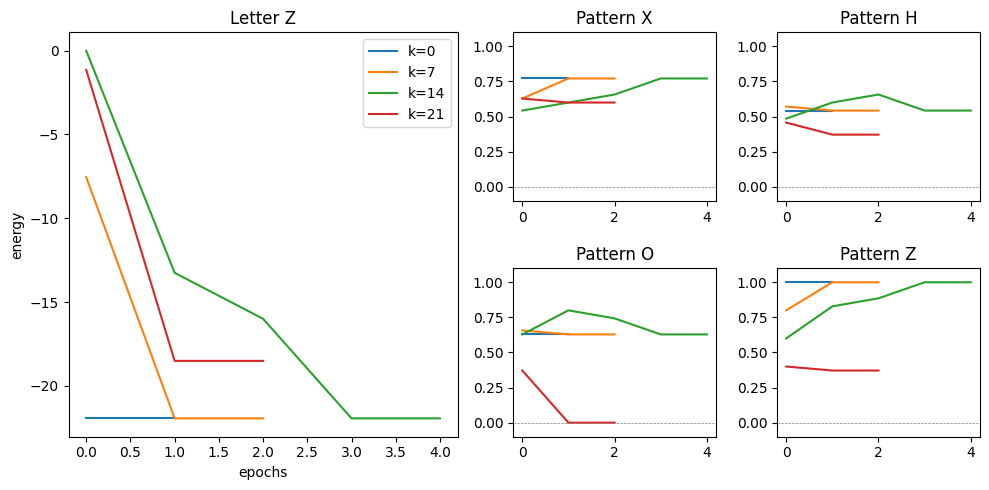

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

for letter_index in range(len(patterns)): 

    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2])  # Left and right half

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Letter {labels[letter_index]}')
    ax0.set_xlabel('epochs')
    ax0.set_ylabel('energy')

    data = [results[k][letter_index] for k in k_noises]
    for i, (states, energies) in enumerate(data):
        ax0.plot(energies, label=f'k={k_noises[i]}')
    ax0.legend()
    gs_right = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1], wspace=0.3, hspace=0.4)

    for i in range(len(patterns)):
        ax = plt.subplot(gs_right[i])
        ax.set_title(f'Pattern {labels[i]}')
        ax.set_ylim(-0.1,1.1)
        for ki, k in enumerate(k_noises):
            overlap_curve = overlaps[k][letter_index][i]
            ax.plot(overlap_curve, label=f'k={k}')
        ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()


## 10000 random

In [33]:
from collections import defaultdict

ta_count = 0
fa_count = 0
lc_count = 0
most_frequent = defaultdict(int)
for i in range(1000):
    # print(f'Iteration {i}')
    rp = np.random.choice([-1, 1], size=35)
    # print(rp)
    states, energies, is_fixed_point = network.run_sync(rp)
    final_state = states[-1]
    
    if not is_fixed_point:
        lc_count += 1
        continue
    
    true_attractor = False
    for p in patterns:
        if np.all(final_state == p) or np.all(final_state == -p):
            true_attractor = True
            break
        
    if true_attractor:
        ta_count += 1
    else:
        fa_count += 1

    if final_state[0] == -1:
        final_state *= -1
    
    most_frequent[tuple(final_state)] += 1
    
print(f'True attractors: {ta_count}')
print(f'False attractors: {fa_count}')
print(f'Limit cycles: {lc_count}')

True attractors: 747
False attractors: 155
Limit cycles: 98


### Plot 10 most frequent states

map size 7


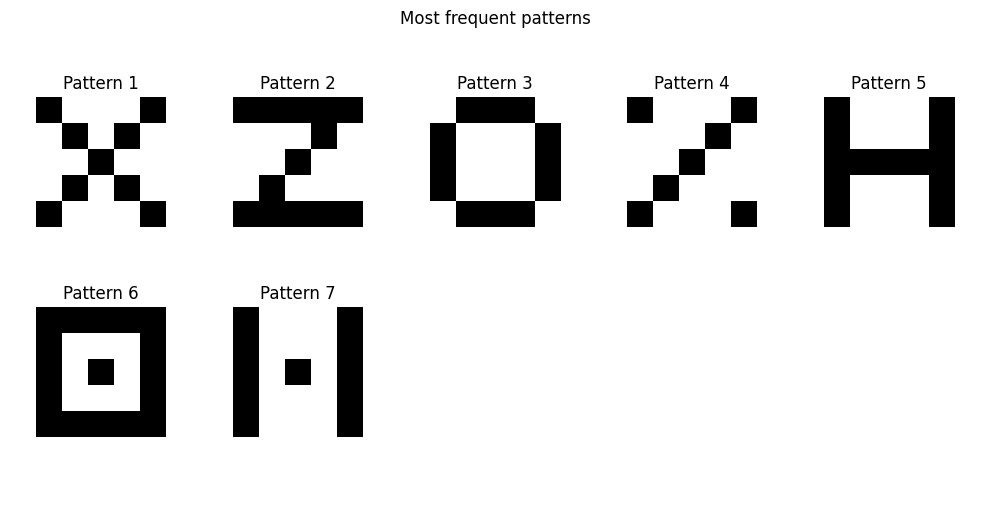

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.title('Most frequent patterns')
plt.axis('off')
print('map size', len(most_frequent))

for i, (key, val) in enumerate(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True)[:10]):
    plt.subplot(2, 5, i+1)
    plt.title(f'Pattern {i+1}')
    plt.imshow(np.array(key).reshape(5, 7), cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()